In [13]:
import numpy as np
from tensorflow.keras import datasets

In [14]:
class Softmax(object):
    
    def __init__(self, epsilon=1e-12):

        self.parameters = {}
        self.epsilon = epsilon

    def forward(self, x):
        '''
        x : (batch_size, feature_size)
        '''
        t = x.max(axis=1).reshape(x.shape[0], 1)
        x -= t
        temp = np.exp(x)
        self.parameters["x"] = temp / (temp.sum(axis=1).reshape(temp.shape[0], 1) + self.epsilon)
        return self.parameters["x"]

    def backward(self, grad):
        s = self.parameters['x']
        sisj = np.matmul(np.expand_dims(s, axis=2), np.expand_dims(s, axis=1))
        g_y_exp = np.expand_dims(grad, axis=1)
        tmp = np.matmul(g_y_exp, sisj)
        tmp = np.squeeze(tmp, axis=1)
        return -tmp + grad * s

    def __call__(self, x):
        return self.forward(x)


In [15]:
class CrossEntropy(object):
    
    def __init__(self, epsilon=1e-12):
        self.epsilon = epsilon
        self.parameters = {}

    def forward(self, x, labels):
        '''
        x : (bathc_size, feature_size)
        labels : (batch_size, feature_size)
        '''
        self.parameters["x"] = x
        self.parameters['labels'] = labels
        lg = -np.log(x)
        return np.mean(np.sum(lg * labels, axis=1))
        

    def backward(self):

        return - 1 / (self.parameters["x"] + self.epsilon) * self.parameters['labels']

    def __call__(self, x, labels):
        return self.forward(x, labels)

In [16]:
class ReLu(object):
    
    def __init__(self):
        
        self.parameters = {}

    def forward(self, x):
        self.parameters["x"] = x
        x[x < 0] = 0
        return x

    def backward(self, grad):
        data = np.where(self.parameters['x'] > 0, 1, self.parameters['x'])
        return data * grad
    
    def __call__(self, x):
        return self.forward(x)

In [17]:
class Linear(object):
    
    def __init__(self, input_size, output_size, learning_rate=1e-3):
        
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.parameters = {
            "W": np.random.normal(size=(input_size, output_size))
        }

    def forward(self, x):
        '''
        x : (batch_size, feature_size)
        '''
        self.parameters["x"] = x
        return np.dot(x, self.parameters["W"])

    def backward(self, grad):
        self.parameters["W"] -= self.learning_rate * np.dot(self.parameters["x"].T, grad)
        return np.dot(grad, self.parameters["W"].T)

    def __call__(self, x):
        return self.forward(x)

In [18]:
class PictureModel(object):
    
    def __init__(self, input_size, output_size, learning_rate):
        
        self.fc1 = Linear(input_size=input_size, output_size=output_size, 
                                                  learning_rate=learning_rate)
        self.act = ReLu()
        self.fc2 = Linear(input_size=output_size, output_size=10, 
                                                  learning_rate=learning_rate)
        self.softmax = Softmax()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return self.softmax(out)

    def __call__(self, x):
        return self.forward(x)

    def backward(self, x, labels):
        criterion = CrossEntropy()
        out = criterion(x, labels)
        grad = criterion.backward()
        grad = self.softmax.backward(grad)
        grad = self.fc2.backward(grad)
        grad = self.act.backward(grad)
        grad = self.fc1.backward(grad)
        return out


In [37]:
my_model = PictureModel(784, 100, learning_rate=1e-5)

In [38]:
def score(labels, predict):
    predict = predict.argmax(axis=1)
    return sum(labels == predict) / len(predict)

In [39]:
(train_dataset, train_label), (test_dataset, test_label) = datasets.mnist.load_data()
train_dataset = train_dataset.reshape(train_dataset.shape[0], -1)
test_dataset = test_dataset.reshape(test_dataset.shape[0], -1)
train_dataset = train_dataset / 255

In [40]:
my_model.fc1.learning_rate = 1e-5
my_model.fc2.learning_rate = 1e-5
average_loss = []
average_acc = []

In [67]:
batch_size = 64
epoch = 300
for e in range(epoch):
    avg_loss = 0
    avg_acc = 0
    for i in range(0, len(train_dataset) // batch_size):
        out = my_model(train_dataset[i * batch_size:(i + 1) * batch_size])
        labels = np.zeros((batch_size, 10))
        for j in range(batch_size):
            labels[j, train_label[i * batch_size + j].item()] = 1
        loss = my_model.backward(out, labels)
        if i % 1000 == 0:
            if i == 0:
                avg_loss = loss
                avg_acc = score(test_label, predicts)
            else:
                avg_loss += loss
                avg_acc += score(test_label, predicts)
                avg_loss /= 2
                avg_acc /= 2
            predicts = my_model(test_dataset)
            print(loss, avg_acc)
    average_acc.append(avg_acc)
    average_loss.append(avg_loss)

In [66]:
average_loss

In [58]:
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 #分辨率

Text(0.5, 1.0, 'pure numpy + Gradient Descent optimizer : accuarcy graph')

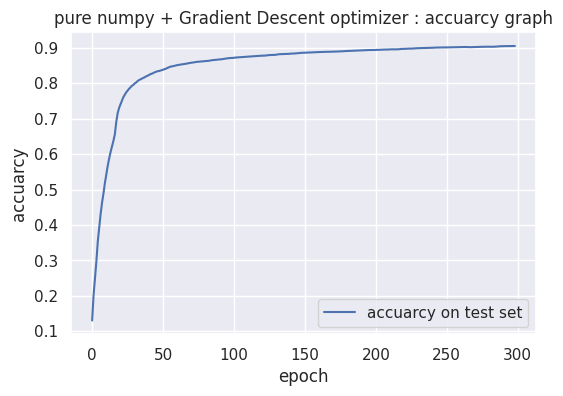

In [63]:
ax2 = sns.lineplot(x = np.arange(0, len(average_loss[1:]), 1),
             y = average_acc[1:], label="accuarcy on test set")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuarcy")
ax2.set_title("pure numpy + Gradient Descent optimizer : accuarcy graph")

Text(0.5, 1.0, 'pure numpy + Gradient Descent optimizer : loss graph')

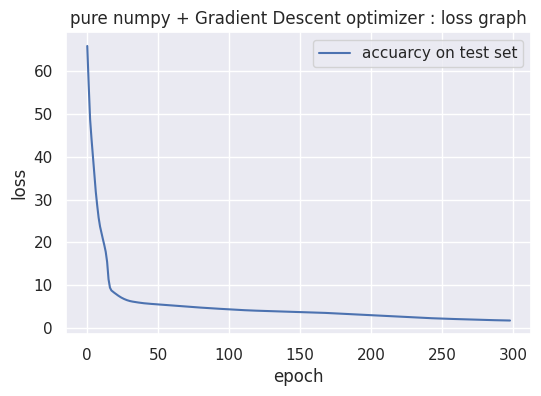

In [65]:
ax2 = sns.lineplot(x = np.arange(0, len(average_loss[1:]), 1),
             y = average_loss[1:], label="accuarcy on test set")
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.set_title("pure numpy + Gradient Descent optimizer : loss graph")